# Trabalho Final da Matéria de Processamento de Imagens - BCC FURB
Classificação de imagens de satélite em "Habitadas" ou "Não habitadas" e aplicação em contexto local.

<b>Turma:</b> SUP-CMP.187.0.2-2024/1<br>
<b>Docente:</b> Aurélio Faustino Hoppe<br>
<b>Discentes:</b> Arthur B Pinotti, Kaue Reblin, Luiz G Klitzke<br>

## Treinando o modelo com o Dataset

In [13]:
from tensorflow import keras

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

import os

In [52]:
# Parâmetros gerais

img_height, img_width = 256, 256
path_dataset = "Dataset"
labels_classes = ["Habitado", "NaoHabitado"]

def get_indice_label(label):
    try:
        return labels_classes.index(label)
    except ValueError:
        return -1 

### Carregar dados do dataset através da estrutura de pastas

In [4]:
#Obtem os datasets de treino e validação através da estrutura de pastas baixada do dataset, usando seus nomes para separar as labels

train_dataset, validation_dataset  = keras.utils.image_dataset_from_directory(
    path_dataset,
    labels = "inferred",
    label_mode = "int",
    class_names = labels_classes,
    color_mode = "rgb",
    batch_size = 32,
    image_size = (img_height, img_width), #Tentativas de diminuir a escala resultam em resultados piores, devido à perda de detalhes já esparsos
    shuffle = True,
    validation_split = 0.3, #Usa n% de dados para validação
    subset = "both",
    verbose =  True,
    seed = 1024,
)

Found 486 files belonging to 2 classes.
Using 341 files for training.
Using 145 files for validation.


### Configurar a rede

In [5]:
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal_and_vertical"),
        keras.layers.RandomRotation(0.2),
        keras.layers.RandomBrightness(0.2),
        keras.layers.RandomContrast(0.2),
    ]
)

# Modelo
cnn = keras.models.Sequential([
    keras.layers.InputLayer(input_shape = (img_height, img_width, 3)),

    #Processo para evitar overfitting caso a rede decore os resultados
    data_augmentation,

    keras.layers.Conv2D(32, (3, 3), activation = "relu", padding = "same"),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(64, (3, 3), activation = "relu", padding = "same"),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(128, (3, 3), activation = "relu", padding = "same"),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(256, (3, 3), activation = "relu", padding = "same"),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Flatten(),

    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(1, activation="sigmoid")
])

cnn.summary()

c:\Users\luizk\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    16,777,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,198,913 (65.61 MB)

 Trainable params: 17,198,913 (65.61 MB)

 Non-trainable params: 0 (0.00 B)

### Treinar a rede

In [7]:
cnn.compile(
    loss="binary_crossentropy", 
    optimizer = keras.optimizers.Adam(learning_rate=0.001), 
    metrics=["accuracy"]
)

# Early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor ="val_loss",
    patience = 5,
    restore_best_weights = True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor = "val_loss",
    factor = 0.2,
    patience = 3,
    min_lr = 0.00001
)

# Treinamento do modelo
history_cnn = cnn.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.6414 - loss: 0.6298 - val_accuracy: 0.6621 - val_loss: 0.4815 - learning_rate: 0.0010
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.7262 - loss: 0.4586 - val_accuracy: 0.6621 - val_loss: 0.4671 - learning_rate: 0.0010
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.6620 - loss: 0.7604 - val_accuracy: 0.6621 - val_loss: 0.5771 - learning_rate: 0.0010
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.7132 - loss: 0.6598 - val_accuracy: 0.6621 - val_loss: 0.5574 - learning_rate: 0.0010
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.7162 - loss: 0.5307 - val_accuracy: 0.6621 - val_loss: 0.5161 - learning_rate: 0.0010
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.7052 - loss: 0.4961 - val_accuracy: 0.6621 - val_loss: 0.4166 - learning_rate: 2.0000e-04
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.7333 - loss: 0.3725 - val_accura

### Avaliar os resultados do treino

In [8]:
# Avaliação do cnno
loss, accuracy = cnn.evaluate(validation_dataset, verbose = 1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - accuracy: 0.9433 - loss: 0.1886


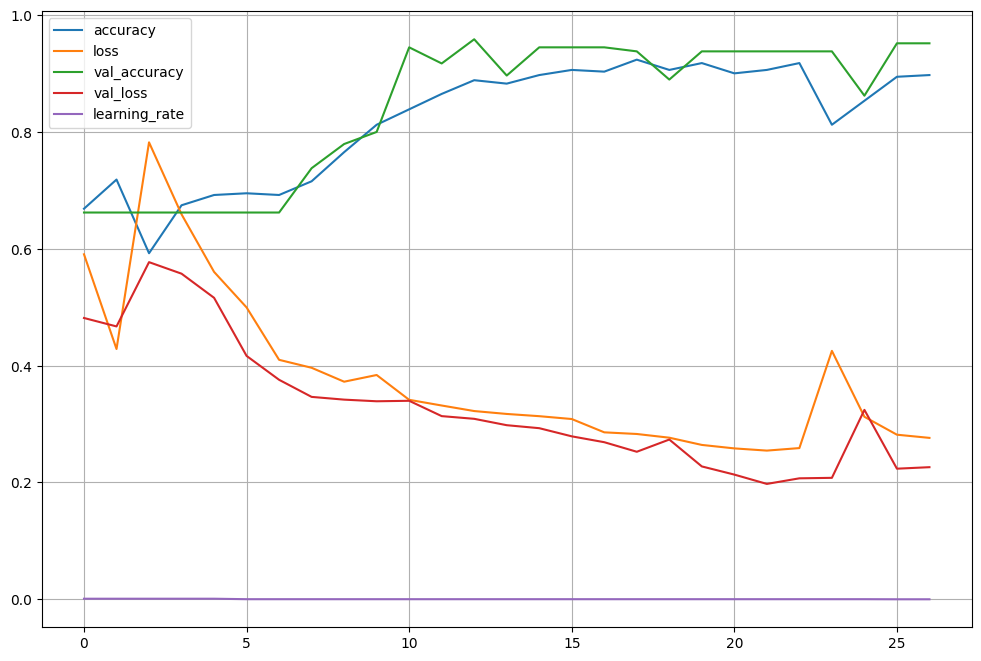

In [10]:
#Apresenta os dados da performânce do algoritmo, atráves do membro history, preenchido com a execução.
pd.DataFrame(history_cnn.history).plot(figsize = (12, 8))
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


<Figure size 800x800 with 0 Axes>

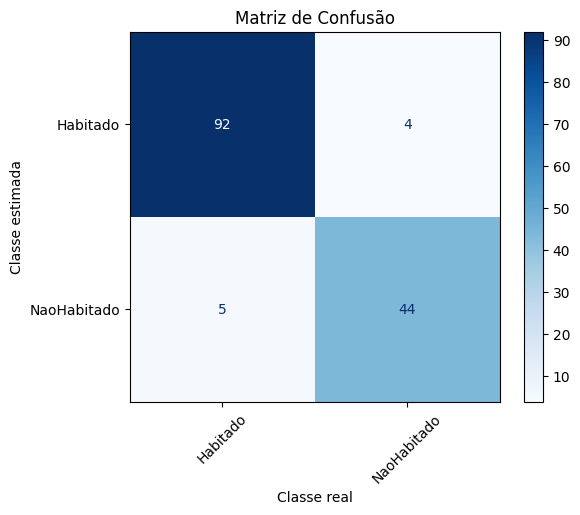

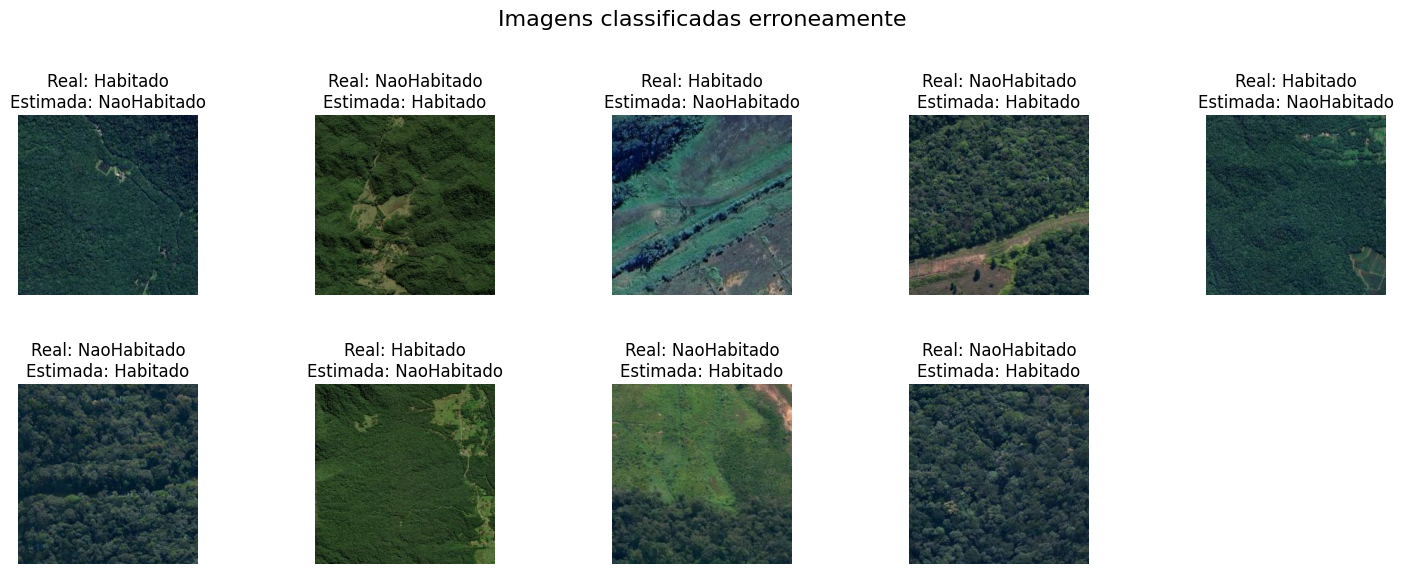

In [58]:
# Arrays para armazenar previsões e labels verdadeiras
labels_reais     = []
labels_estimadas = []

# Arrays para armazenar imagens e labels que não coincidem
comparacao_imagem           = []
comparacao_labels_reais     = []
comparacao_labels_estimadas = []

# Iterar sobre o conjunto de validação e fazer previsões
for images, labels in validation_dataset:
    estimativas = cnn.predict(images)
    estimativas = (estimativas > 0.5).astype("int32").flatten()

    labels_estimadas.extend(estimativas)
    labels_reais.extend(labels.numpy())

    for i in range(len(estimativas)):
        if estimativas[i] != labels.numpy()[i]:
            comparacao_imagem          .append(images[i].numpy())
            comparacao_labels_reais    .append(labels.numpy()[i])
            comparacao_labels_estimadas.append(estimativas[i])

labels_estimadas = np.array(labels_estimadas).flatten()
labels_reais     = np.array(labels_reais    ).flatten()

def monta_matriz_confusao(labels_reais, labels_estimadas, titulo):
    cm = confusion_matrix(labels_reais, labels_estimadas)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels_classes)

    # Plotar a matriz de confusão
    plt.figure(figsize = (8, 8))
    disp.plot(cmap = plt.cm.Blues)
    plt.title(titulo)
    plt.xlabel("Classe real")
    plt.ylabel("Classe estimada")
    plt.xticks(rotation =  45)

monta_matriz_confusao(labels_reais, labels_estimadas, "Matriz de Confusão")

def mostra_grid_classificacao(imagens, labels_reais, predicted_labels, titulo):
    num_images_per_row = 5
    num_images = len(imagens)
    num_rows = (num_images + num_images_per_row - 1) // num_images_per_row

    plt.figure(figsize = (15, num_rows * 3))
    plt.suptitle(titulo, fontsize = 16)

    for i in range(num_images):
        ax = plt.subplot(num_rows, num_images_per_row, i + 1)
        plt.imshow(imagens[i].astype("uint8"))
        true_label = labels_classes[int(labels_reais[i])]
        predicted_label = labels_classes[int(predicted_labels[i])]
        plt.title(f"Real: {true_label}\nEstimada: {predicted_label}")
        plt.axis("off")

    plt.tight_layout(h_pad = 4, rect = [0, 0.03, 1, 0.95])	
    plt.show()

# Plotar as imagens classificadas erroneamente
if (len(comparacao_imagem) != 0):
    mostra_grid_classificacao(comparacao_imagem, comparacao_labels_reais, comparacao_labels_estimadas, "Imagens classificadas erroneamente")

### Salvar rede já treinada, para uso posterior

In [12]:
cnn.save("resultados/redes/treinamento.keras")

### Caregar rede já treinada - sobrescrever o treinamento realizado agora

In [26]:
cnn = keras.models.load_model("resultados/redes/treinamento.keras")

## Aplicação em imagens de munícipios próximos

Agora avaliaremos a aplicabilidade do modelo treinado, processando algumas imagens de satélite de munícipios próximos, obtidas pelos membros do grupo.

RioDosCedros
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


C:\Users\luizk\AppData\Local\Temp\ipykernel_16828\3808446944.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_estimada = int((pred > 0.5).astype("int32").flatten())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


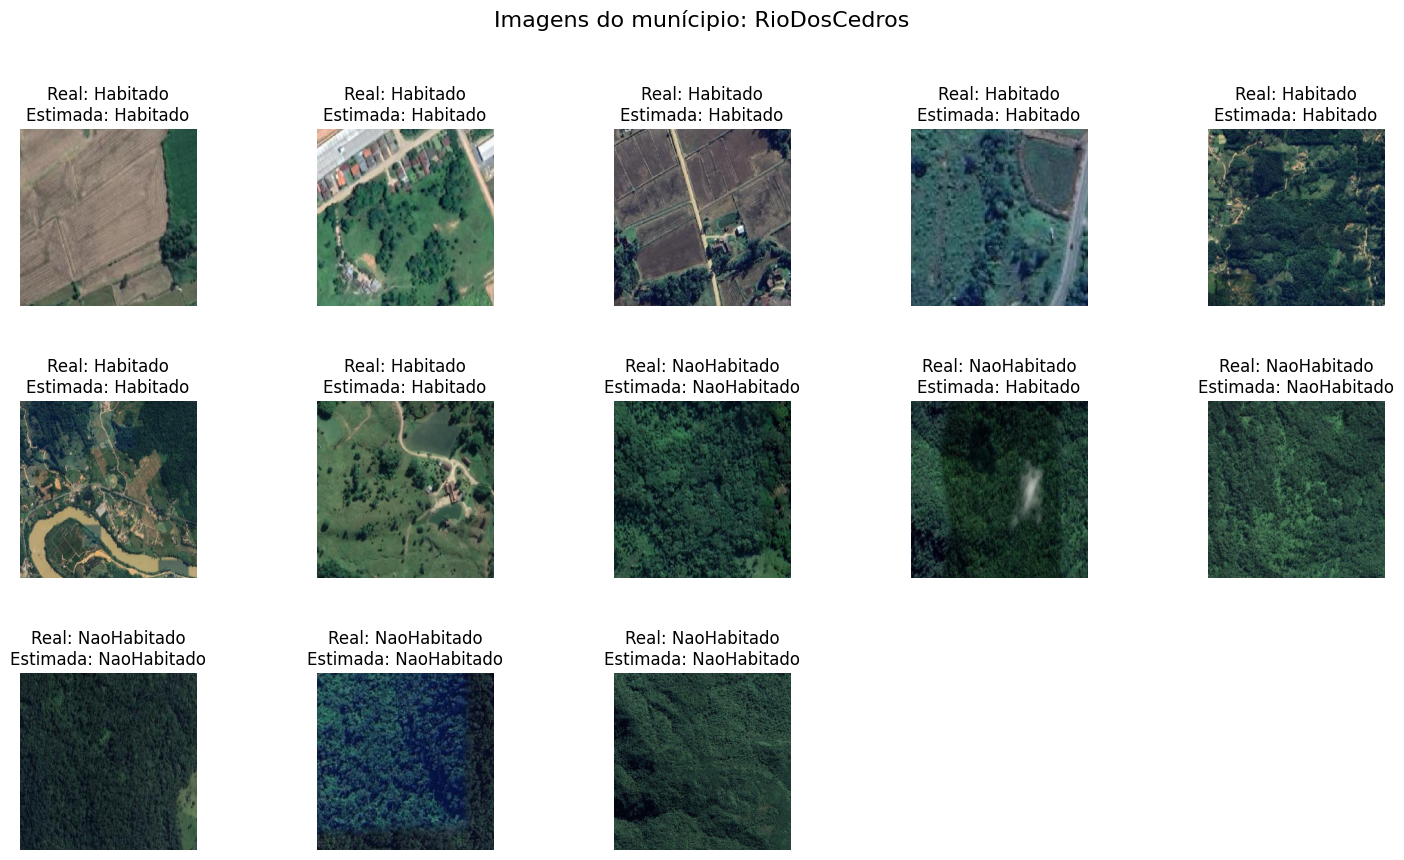

Timbo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


C:\Users\luizk\AppData\Local\Temp\ipykernel_16828\3808446944.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_estimada = int((pred > 0.5).astype("int32").flatten())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


<Figure size 800x800 with 0 Axes>

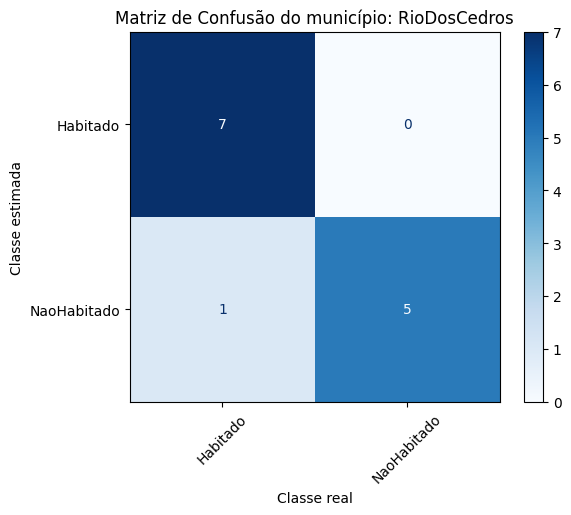

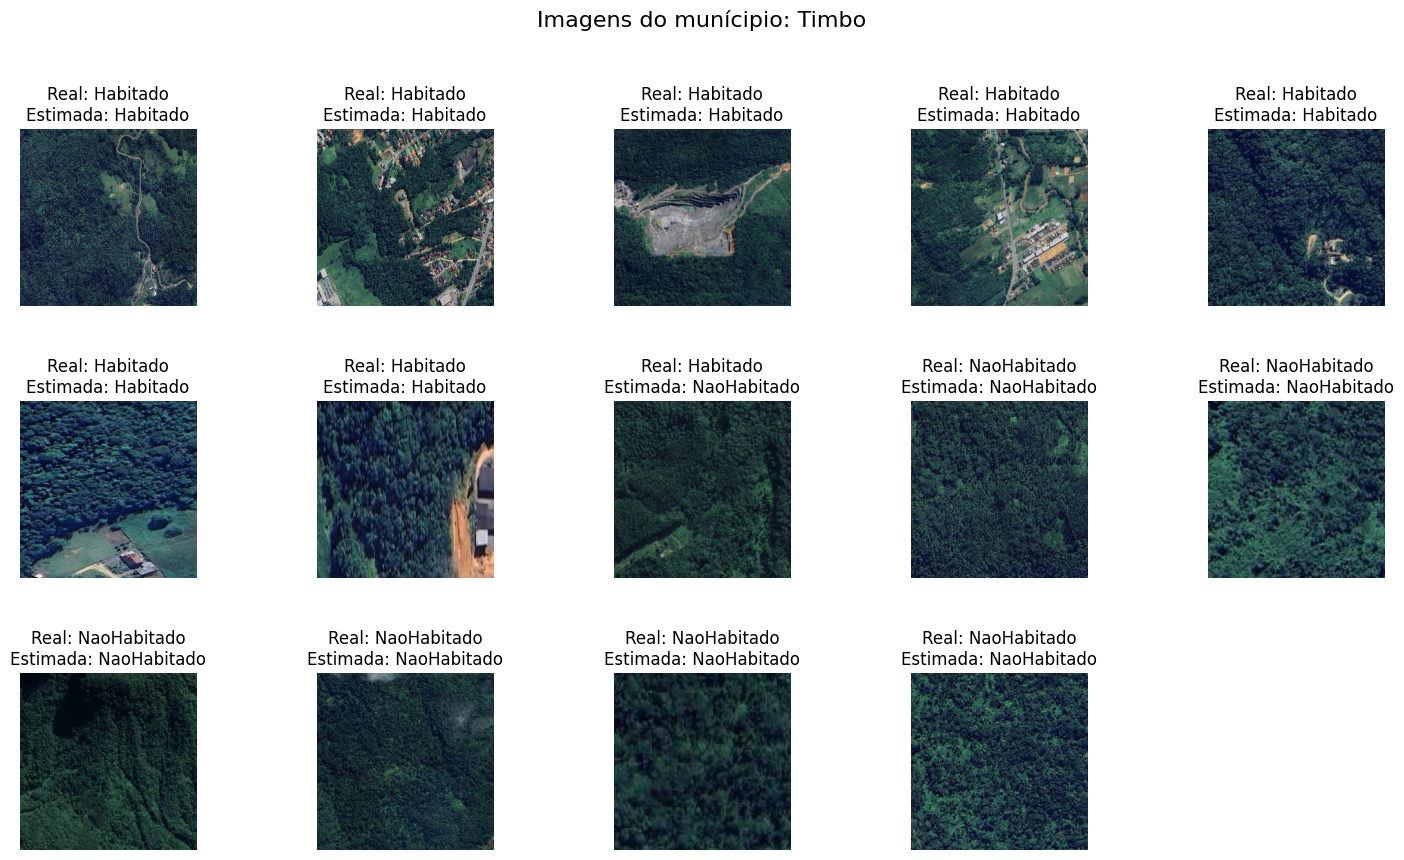

<Figure size 800x800 with 0 Axes>

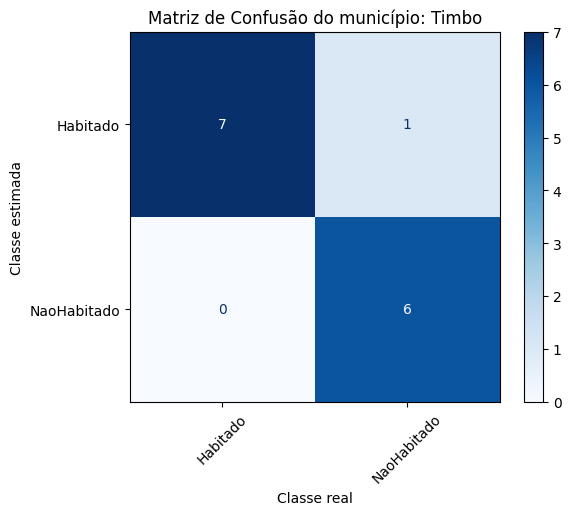

In [60]:
path_locais = "ImagensLocais"

def processa_municipio(nome_muncipio, path_municipio):
    imagens = []
    labels_reais = []
    labels_estimadas = []
    
    for root, dirs, files in os.walk(path_municipio):
        for file in files:
            path_imagem = os.path.join(root, file)
            label_real = os.path.basename(root)
            labels_reais.append(get_indice_label(label_real))
            img = keras.utils.load_img(path = path_imagem, target_size = (img_height, img_width), keep_aspect_ratio = False)

            img_array = keras.utils.img_to_array(img)
            imagens.append(img_array)
            img_array = np.expand_dims(img_array, axis = 0)

            pred = cnn.predict(img_array)
            label_estimada = int((pred > 0.5).astype("int32").flatten())
            labels_estimadas.append(label_estimada)

    mostra_grid_classificacao(imagens, labels_reais, labels_estimadas, f"Imagens do munícipio: {nome_muncipio}")
    monta_matriz_confusao(labels_reais, labels_estimadas, f"Matriz de Confusão do município: {nome_muncipio}")

with os.scandir(path_locais) as itens_pasta:
    for item in itens_pasta:
        if item.is_dir(): #Cada munícipio é uma pasta
            print(item.name)
            processa_municipio(item.name, os.path.join(path_locais, item.name))